In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
#from scipy.optimize import least_squares
from scipy.optimize import curve_fit

In [10]:
job = Gaia.launch_job_async("select top 10000 * from gaiadr2.vari_cepheid order by source_id")
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [11]:
#r

In [12]:
#np.sort(r['pf'])

In [1]:
sources = r['source_id']

NameError: name 'r' is not defined

### Light curves with flux

In [14]:
lcs = np.loadtxt('light_curves_first.txt',skiprows=1,delimiter=',',usecols=(0,3,4,5,6,7))
lcs_band = np.loadtxt('light_curves_first.txt',skiprows=1,delimiter=',',usecols=2, dtype=np.str)

In [15]:
source_id = lcs[:,0]
band = lcs_band
time = lcs[:,1]
mag = lcs[:,2]
flux = lcs[:,3]
flux_error = lcs[:,4] 
flux_over_error = lcs[:,5]
print(source_id)

[2.94523644e+18 2.94523644e+18 2.94523644e+18 ... 2.96334763e+18
 2.96334763e+18 2.96334763e+18]


### Regarding the determination of periods:
https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_variability_tables/ssec_dm_vari_cepheid.html

"This value [pf] is obtained by modelling the G band time series using the Levenberg-Marquardt non linear fitting algorithm (see Clementini et al. 2016, A&A, 595, A133)."

Also worth noting, from the same webpage:

"The intensity-averaged magnitude is obtained by computing the average flux and then converting the average flux to magnitude."

## Flux with error bars

In [16]:
asas_flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
asas_flux_error_G = asas_flux_error[G_ind[0][0]:G_ind[-1][0]]
plt.errorbar(phase, asas_flux_G, yerr=asas_flux_error_G, ls='None', ecolor='k', capsize=2)
plt.scatter(phase, asas_flux_G, color='g')
plt.title('Light Curve for ' + str(mysource) +', Per = '+ str('%.3f'%per))
plt.xlabel('Phase')
plt.ylabel('G Band Flux')
#plt.savefig('LCPhase'+str(mysource)+'.png', bboxes='tight', dpi=300)
plt.show()

NameError: name 'asas_ind' is not defined

## Modeling a Fourier Series to the Light Curve

In [17]:
myperiod = r['pf'][np.argwhere(r['source_id']==mysource)]
myperiod = myperiod[0][0]
mytime = asas_time_G
myflux = asas_flux_G
mymag = asas_mag_G
def fourier3(tau,c,a,b):
    #argument: tau = (2*np.pi*t)/P 
    return c + a*np.sin(tau) + b*np.cos(tau)

def fit_fourier3(t, p, f):
    #c_min = 0
    #c_max = np.inf
    #bound_min = [c_min,c_min,c_min]
    #bound_max = [c_max,c_max,c_max]
    #bound = (bound_min,bound_max)
    popt = curve_fit(fourier3, t%p, f, bounds=(0,np.inf))#=bound)
    pcov = popt[1]
    popt = popt[0]
    #c = popt[0]
    #a = popt[1]
    #b = popt[2]
    return popt #c, a, b

NameError: name 'mysource' is not defined

In [ ]:
fit_fourier3(mytime, myperiod, myflux)

In [ ]:
fit_c = fit_fourier3(mytime, myperiod, myflux)[0]
fit_a = fit_fourier3(mytime, myperiod, myflux)[1]
fit_b = fit_fourier3(mytime, myperiod, myflux)[2]
tau = mytime #2*np.pi*mytime/myperiod
#tau = np.linspace(0,10,num=42)
fit = fit_c + fit_a*np.sin(tau) + fit_b*np.cos(tau)
#plt.plot(mytime, fit, c='r')
#plt.plot(mytime, myflux, c='g')
#plt.show()

In [ ]:
tau = np.linspace(0,2.6,num=42)#mytime #2*np.pi*mytime/myperiod
#tau = mytime % myperiod #The same, as I've defined it now (8am)
fit = fit_c + fit_a*np.sin(tau) + fit_b*np.cos(tau)
#plt.plot(tau, fit, c='r')
#plt.scatter(mytime % myperiod, myflux, c='g')
#plt.show()

### Fourier series fit

In [19]:
N = 42 # number of data points
myt = mytime % myperiod
data = myflux
#first guesses
guess_freq = 1
guess_amplitude = 3*np.std(data)/(2**0.5)
#guess_phase = 0
guess_offset = np.mean(data)
p0=[guess_freq, guess_amplitude, guess_amplitude, guess_amplitude, guess_amplitude, guess_offset]
#create the function we want to fit
def my_sin(x, freq, amplitude1, amplitude2, amplitude3, amplitude4, offset):
    deg1 = (np.sin(2*np.pi*x*freq)*amplitude1) + (np.cos(2*np.pi*x*freq)*amplitude2)
    deg2 = (np.sin(2*np.pi*2*x*freq)*amplitude3) + (np.cos(2*np.pi*2*x*freq)* amplitude4)
    return offset + deg1 + deg2
#now do the fit
fit = curve_fit(my_sin, myt, data, p0=p0)
#recreate the fitted curve using the optimized parameters
data_fit = my_sin(myt, *fit[0])
plt.plot(data, '.', label='light curve points',c='g')
plt.plot(data_fit, label='light curve fit', c='r')
plt.legend()
plt.show()

NameError: name 'mytime' is not defined

In [ ]:
plt.plot(mytime, data, label='light curve points',c='g')
plt.plot(mytime, data_fit, label='light curve fit', c='r')
plt.legend()
plt.show()

In [ ]:
plt.scatter(mytime%myperiod, data, label='light curve points',c='g')
plt.scatter(mytime%myperiod, data_fit, label='light curve fit', c='r')
plt.legend()
plt.title('First Fit with Four Amplitude Unkowns')
#plt.savefig
plt.show()

In [ ]:
fit[0]

In [ ]:
myfreq = fit[0][0] 
myamp1 = fit[0][1]  
myamp2 = fit[0][2]
myamp3 = fit[0][3]
myamp4 = fit[0][4]
myoffset = fit[0][5]
x = np.linspace(0,2.6,num=3125)
fitcurve = my_sin(x, myfreq,myamp1,myamp2,myamp3,myamp4,myoffset)
plt.scatter(mytime%myperiod, myflux, c='g')
plt.plot(x, fitcurve, c='r')
plt.show()

In [ ]:
x = np.linspace(min(mytime%myperiod),max(mytime%myperiod),num=3125)
plt.errorbar(phase, asas_flux_G, yerr=asas_flux_error_G, ls='None', ecolor='k', capsize=2)
plt.scatter(mytime%myperiod, myflux, c='g')
plt.plot(x, fitcurve, c='r')
plt.title('New Fitted Light Curve for ' + str(mysource))
plt.xlabel('Phase')
plt.ylabel('G Band Flux')
#plt.savefig('LCPhase'+str(mysource)+'_4AmpFit.png', bboxes='tight', dpi=300)
plt.show()

In [ ]:
print(np.mean(data))
print(np.mean(data_fit))
print(np.mean(fitcurve))
print(myoffset)

## Same method as above, but with magnitude instead of flux

In [ ]:
N = 42 # number of data points
myt = mytime % myperiod
t = np.linspace(0, 4*np.pi, N)
data = mymag

guess_freq = 1
guess_amplitude = 3*np.std(data)/(2**0.5)
#guess_phase = 0
guess_offset = np.mean(data)

p0=[guess_freq, guess_amplitude, guess_amplitude, guess_amplitude, guess_amplitude, guess_offset]

# create the function we want to fit
def my_sin(x, freq, amplitude1, amplitude2, amplitude3, amplitude4, offset):
    deg1 = (np.sin(2*np.pi*x*freq)*amplitude1) + (np.cos(2*np.pi*x*freq)*amplitude2)
    deg2 = (np.sin(2*np.pi*2*x*freq)*amplitude3) + (np.cos(2*np.pi*2*x*freq)* amplitude4)
    return offset + deg1 + deg2

# now do the fit
fit_mag = curve_fit(my_sin, myt, data, p0=p0)

# recreate the fitted curve using the optimized parameters
data_fit_mag = my_sin(myt, *fit_mag[0])

plt.plot(mymag, '.', label='light curve points',c='g')
plt.plot(data_fit_mag, label='light curve fit', c='r')
plt.legend()
plt.show()

In [ ]:
plt.scatter(mytime%myperiod, mymag,c='g')
plt.gca().invert_yaxis()
plt.scatter(mytime%myperiod, data_fit_mag, label='light curve fit', c='r')
#plt.legend()
plt.show()

In [ ]:
magfreq = fit_mag[0][0] 
magamp1 = fit_mag[0][1] 
magamp2 = fit_mag[0][2] 
magamp3 = fit_mag[0][3] 
magamp4 = fit_mag[0][4] 
magoffset = fit_mag[0][5]
x = np.linspace(min(mytime%myperiod),max(mytime%myperiod),num=3125)
fitcurvemag = my_sin(x,magfreq,magamp1,magamp2,magamp3,magamp4,magoffset)
plt.scatter(mytime%myperiod, mymag, c='g')
plt.plot(x, fitcurvemag, c='r')
plt.gca().invert_yaxis()
plt.title('Fitted Light Curve for ' + str(mysource))
plt.xlabel('Phase')
plt.ylabel('Mag')
#plt.savefig('LCPhase'+str(mysource)+'_Fit_Mag.png', bboxes='tight', dpi=300)
plt.show()

In [ ]:
print(fit_mag[0])
print(fit[0])

In [ ]:
print(np.mean(mymag))
print(np.mean(data_fit_mag))
print(np.mean(fitcurvemag))
print(r['int_average_g'][np.argwhere(r['source_id']==mysource)])

## Zero-Point Comparison

In [ ]:
print(myoffset)
print(2.5*np.log10(myoffset))
print(magoffset)

## Importaning large numbers (i.e. large source IDs) correctly

In [20]:
lcs = np.loadtxt('lcs_2981.txt',skiprows=1,delimiter=',',usecols=(0,3,4,5,6,7))
lcs_wrong = np.loadtxt('lcs_2981.txt',skiprows=1,delimiter=',',usecols=0)
lcs_right = np.loadtxt('lcs_2981.txt',skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
print(int(lcs_wrong[0]))
print(lcs_right[0])

2981571592580414464
2981571592580414592


## Finding a better source

Index = 532
Source = 2931247014102560000
Period = 5.728612642149489


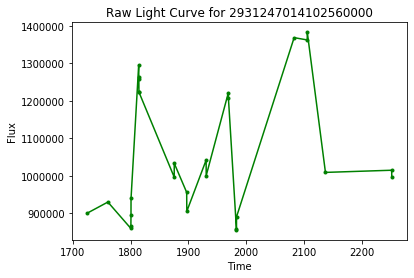

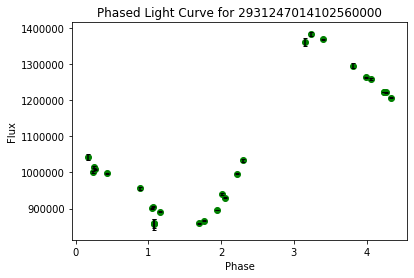

Index = 533
Source = 2932101334643047680
Period = 2.55777974834585


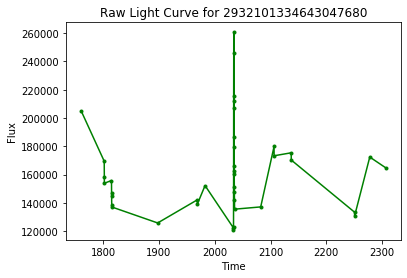

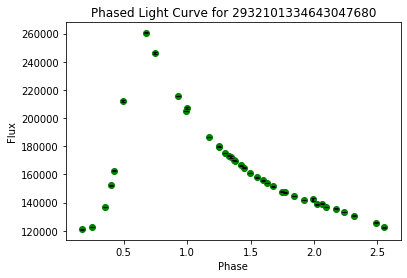

Index = 534
Source = 2932737092877188352
Period = 3.155041186359865


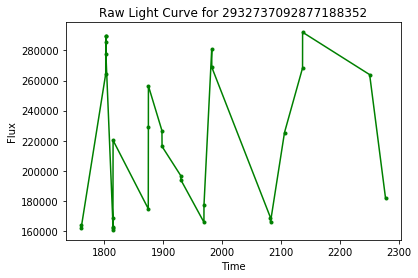

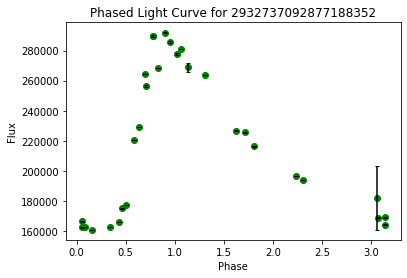

Index = 535
Source = 2933016781147478272
Period = 4.73504995929658


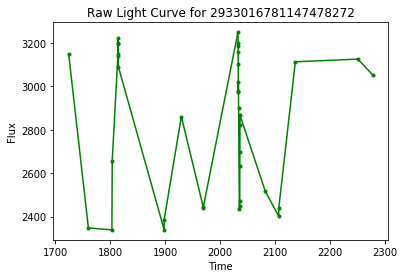

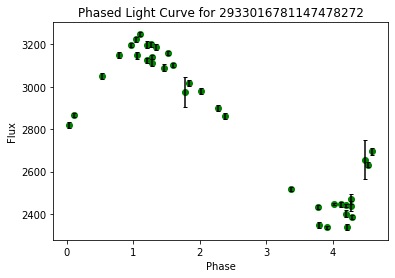

Index = 536
Source = 2934255449716149760
Period = 2.5465295076198418


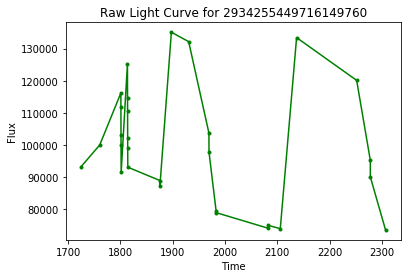

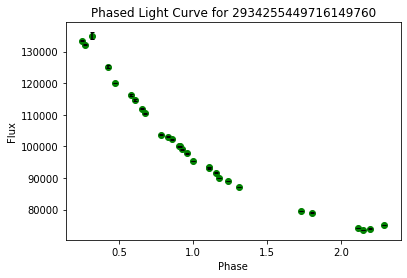

Index = 537
Source = 2934506447605426944
Period = 4.204866924622961


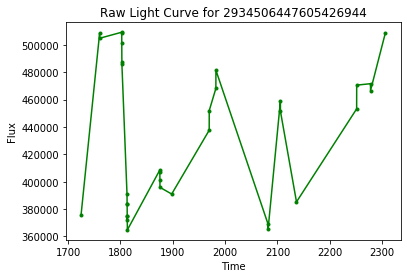

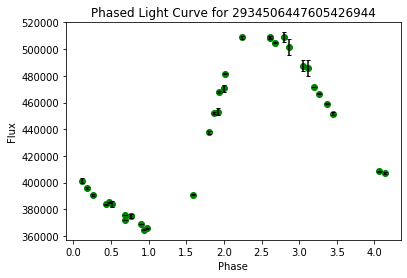

Index = 538
Source = 2934712880912798464
Period = 7.512107388023423


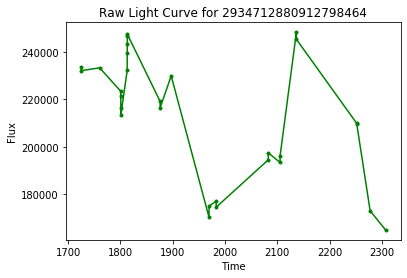

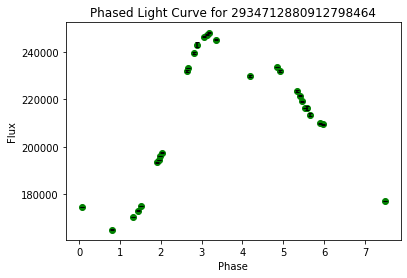

Index = 541
Source = 2936110669428633216
Period = 4.464839323922715


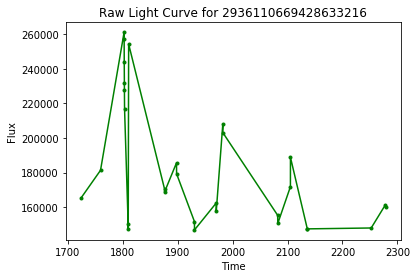

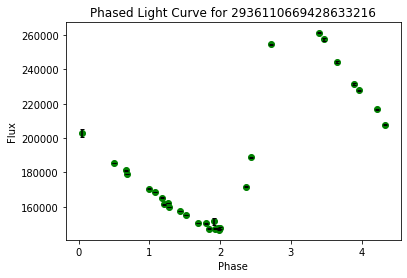

Index = 542
Source = 2936165984303583360
Period = 3.5228105557194183


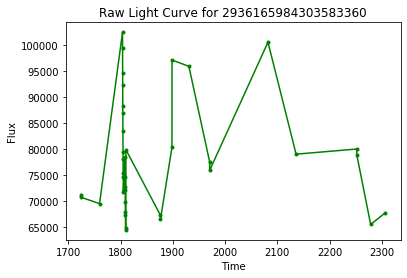

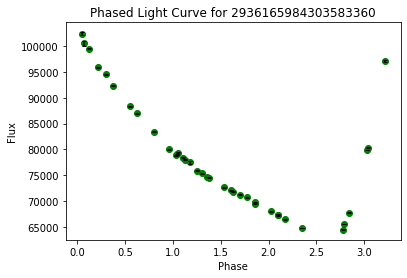

Index = 543
Source = 2936194782069439872
Period = 1.8656989962520527


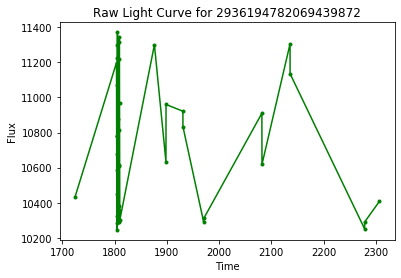

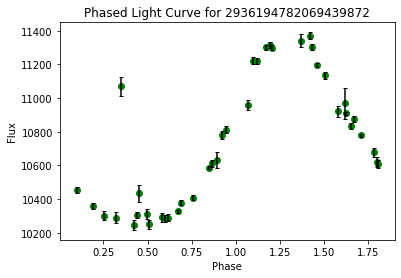

In [21]:
file = 'lcs_2930.txt'
lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(0,3,4,5,6,7))
source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
#source_id = lcs[:,0]
time = lcs[:,1]
mag = lcs[:,2]
flux = lcs[:,3]
flux_error = lcs[:,4] 
flux_over_error = lcs[:,5]
sources = np.loadtxt('vari_cepheids.txt', dtype=np.int64)
for i in range (0, 3125):
    asas_ind = np.argwhere(source_id==int(sources[i]))
    if len(asas_ind) == 0:
        continue
    per = r['pf'][np.argwhere(r['source_id']==sources[i])]
    per = per[0][0]
    if str(per) == '--':
        continue
    print('Index = ' + str(i))
    print('Source = ' + str(sources[i]))
    print('Period = ' + str(per))
    #Properties of each source
    asas_mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
    asas_time = time[asas_ind[0][0]:asas_ind[-1][0]]
    asas_flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
    asas_band = band[asas_ind[0][0]:asas_ind[-1][0]]
    asas_flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
    #Properties of each source seperated by band
    G_ind = np.argwhere(asas_band=='G')
    #if len(G_ind) == 0:
        #continue
    asas_time_G = asas_time[G_ind[0][0]:G_ind[-1][0]]
    asas_mag_G = asas_mag[G_ind[0][0]:G_ind[-1][0]]
    asas_flux_G = asas_flux[G_ind[0][0]:G_ind[-1][0]]
    asas_flux_error_G = asas_flux_error[G_ind[0][0]:G_ind[-1][0]]
    #Plotting light curves
    phase = (asas_time_G % per)
    plt.plot(asas_time_G, asas_flux_G, 'g.-')
    plt.title('Raw Light Curve for ' + str(int(sources[i])))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.show()
    plt.scatter(phase, asas_flux_G, c='g')
    plt.errorbar(phase, asas_flux_G, yerr=asas_flux_error_G, ls='None', ecolor='k', capsize=2)
    plt.title('Phased Light Curve for ' + str(int(sources[i])))
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    #plt.xlabel('Time (s)')
    #plt.ylabel('Mag')
    #plt.savefig('LightCurve'+str(int(sources[i]))+'.png', bboxes='tight', dpi=300)
    plt.show()

## A nice steep curve: Source 2932101334643047680

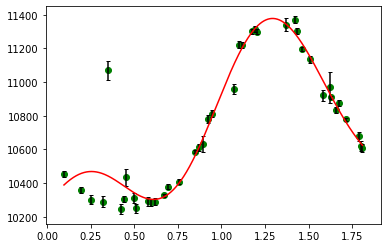

In [22]:
#mysource = 2932101334643047680
mysource = 2936194782069439872
#mysource = 2945995416399061760

file = 'lcs_2930.txt'
#file = 'light_curves_first.txt'
lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(0,3,4,5,6,7))
source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
time = lcs[:,1]
mag = lcs[:,2]
flux = lcs[:,3]
flux_error = lcs[:,4] 
per = r['pf'][np.argwhere(r['source_id']==mysource)]
per = per[0][0]

asas_ind = np.argwhere(source_id==mysource)
mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
time = time[asas_ind[0][0]:asas_ind[-1][0]]
flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
#Seperating bands
band = band[asas_ind[0][0]:asas_ind[-1][0]]
G_ind = np.argwhere(band=='G')
time_G = time[G_ind[0][0]:G_ind[-1][0]]
mag_G = mag[G_ind[0][0]:G_ind[-1][0]]
flux_G = flux[G_ind[0][0]:G_ind[-1][0]]
flux_error_G = flux_error[G_ind[0][0]:G_ind[-1][0]]

###Three Degree Fourier Fit

#def SixDegFit(lcfile):
myt = time_G % per
data = flux_G
N = len(data)
#first guesses
guess_freq = 1
guess_amp = 3*np.std(data)/(2**0.5)
guess_offset = np.mean(data)
p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_offset]

#create the function we want to fit
def my_sin(x,freq,amp1,amp2,amp3,amp4,amp5,amp6,offset):
    deg1 = (np.sin(2*np.pi*x*freq)*amp1) + (np.cos(2*np.pi*x*freq)*amp2)
    deg2 = (np.sin(2*np.pi*2*x*freq)*amp3) + (np.cos(2*np.pi*2*x*freq)* amp4)
    deg3 = (np.sin(2*np.pi*3*x*freq)*amp5) + (np.cos(2*np.pi*3*x*freq)* amp6)
    return offset + deg1 + deg2 + deg3

#now do the fit
fit = curve_fit(my_sin, myt, data, p0=p0)
#print(fit[0])
#recreate the fitted curve using the optimized parameters
#Plotting
phase = time_G % per
plt.errorbar(phase, flux_G, yerr=flux_error_G, ls='None', ecolor='k', capsize=2)
plt.scatter(phase, flux_G, c='g')
x = np.linspace(min(phase),max(phase),num=3125)
fitcurve = my_sin(x, *fit[0])
plt.plot(x, fitcurve, c='r')
plt.show()

## Three Degree Fourier Fit For Loop

In [65]:
def ThreeDegFit(file):
    lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
    source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
    band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
    time = lcs[:,0]
    mag = lcs[:,1]
    flux = lcs[:,2]
    flux_error = lcs[:,3] 
    #flux_over_error = lcs[:,4]
    
    ceph_sources = np.loadtxt('vari_cepheids.txt', dtype=np.int64)
    for i in range(0, len(ceph_sources)):
        #if ceph_sources[i] != 2936194782069439872:
            #continue
        asas_ind = np.argwhere(source_id==ceph_sources[i])
        if len(asas_ind) == 0:
            continue
        per = r['pf'][np.argwhere(r['source_id']==ceph_sources[i])]
        per = per[0][0]
        if str(per) == '--':
            continue
        print('Index = ' + str(i))
        print('Source = ' + str(sources[i]))
        print('Period = ' + str(per))
        #Properties of each source
        asas_mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
        asas_time = time[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
        asas_band = band[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
        #Properties of each source seperated by band
        G_ind = np.argwhere(asas_band=='G')
        #if len(G_ind) == 0:
            #continue
        asas_time_G = asas_time[G_ind[0][0]:G_ind[-1][0]]
        asas_mag_G = asas_mag[G_ind[0][0]:G_ind[-1][0]]
        asas_flux_G = asas_flux[G_ind[0][0]:G_ind[-1][0]]
        asas_flux_error_G = asas_flux_error[G_ind[0][0]:G_ind[-1][0]]
        #Fit
        myt = asas_time_G % per
        data = asas_flux_G
        #N = len(data)
        #first guesses
        guess_freq = 1
        guess_amp = 3*np.std(data)/(2**0.5)
        guess_offset = np.mean(data)
        p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_offset]

        #create the function we want to fit
        #Maybe letting frequency NOT be an unknown can fix things.
        def my_sin(x,freq,amp1,amp2,amp3,amp4,amp5,amp6,offset):
            freq = 1/per
            deg1 = (np.sin(2*np.pi*x*freq)*amp1) + (np.cos(2*np.pi*x*freq)*amp2)
            deg2 = (np.sin(2*np.pi*2*x*freq)*amp3) + (np.cos(2*np.pi*2*x*freq)* amp4)
            deg3 = (np.sin(2*np.pi*3*x*freq)*amp5) + (np.cos(2*np.pi*3*x*freq)* amp6)
            return offset + deg1 + deg2 + deg3

        #now do the fit
        fit = curve_fit(my_sin, myt, data, p0=p0)
        #print(fit[0])
        print('C_flux = ' + str(fit[0][-1]))
        
        
        #repeat for magnitude
        data2 = asas_mag_G
        guess_freq2 = 1
        guess_amp2 = 3*np.std(data2)/(2**0.5)
        guess_offset2 = np.mean(data2)
        p02=[guess_freq,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_offset2]
        fit2 = curve_fit(my_sin, myt, data2, p0=p02)
        #print(fit2[0])
        print('C_mag = ' + str(fit2[0][-1]))
        C_flux = fit[0][-1]
        C_calc = - 2.5*np.log10(C_flux) - -25.688365725119546
        print('C_calc = ' + str(C_calc))
        
        #recreate the fitted curve using the optimized parameters
        #Plotting flux
        phase = asas_time_G % per
        plt.errorbar(phase, asas_flux_G, yerr=asas_flux_error_G, ls='None', ecolor='k', capsize=2)
        plt.scatter(phase, asas_flux_G, c='g')
        x = np.linspace(min(phase),max(phase),num=3125)
        fitcurve = my_sin(x, *fit[0])
        plt.plot(x, fitcurve, c='r')
        plt.title('Light Curve for ' + str(ceph_sources[i]) +', Per = '+ str('%.3f'%per))
        plt.xlabel('Phase')
        plt.ylabel('G Band Flux')
        #plt.savefig('LCfit_'+str(ceph_sources[i])+'_flux.png', bboxes='tight', dpi=300)
        plt.show()
        #Plotting mag
        plt.scatter(phase, asas_mag_G, c='b')
        fitcurve2 = my_sin(x, *fit2[0])
        plt.plot(x, fitcurve2, c='r')
        plt.title('Light Curve for ' + str(ceph_sources[i]) +', Per = '+ str('%.3f'%per))
        plt.xlabel('Phase')
        plt.ylabel('Vega Magnitude')
        plt.gca().invert_yaxis()
        #plt.savefig('LCfit_'+str(ceph_sources[i])+'_mag.png', bboxes='tight', dpi=300)
        plt.show()
        av_mag_mag = np.mean(fitcurve2)
        av_mag_flux = 2.5*np.log10((np.mean(fitcurve)))
        #print(av_mag_mag)
        #print(av_mag_flux)
        C_calc = fitcurve2[0]-(2.5*np.log10(fitcurve[0])) 
        print('C_calc = ' + str(C_calc))

Index = 584
Source = 3046201126584979584
Period = 1.8676208597739372
C_flux = 30117.276292487204
C_mag = 14.507737604429158
C_calc = 14.491326492273146


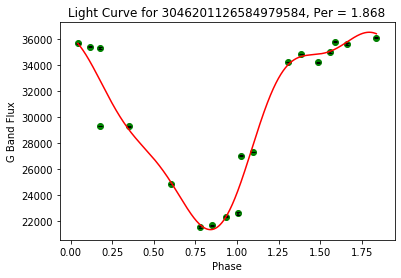

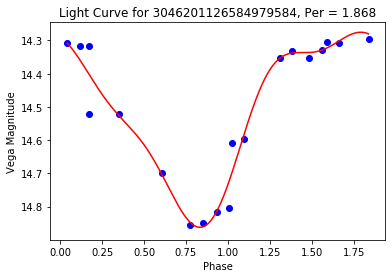

C_calc = 2.9269581082434843
Index = 585
Source = 3046774762417915136
Period = 4.6782999640058325
C_flux = 13893763.60911497
C_mag = 7.848822458640779
C_calc = 7.831315961519188


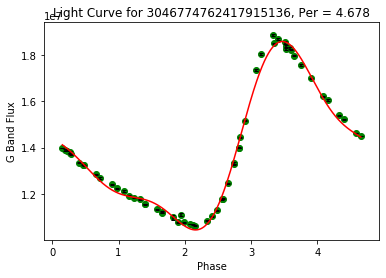

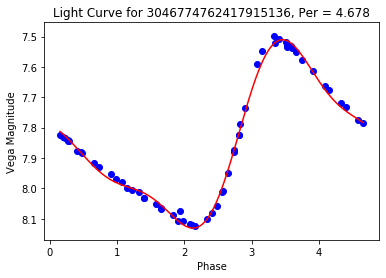

C_calc = -10.061814886686197
Index = 587
Source = 3050050207554658048
Period = 8.011272475158572
C_flux = 2730474.2533151167
C_mag = 9.609018439175914
C_calc = 9.59777051071384


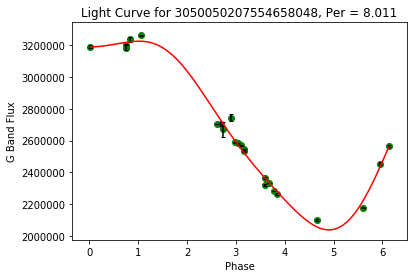

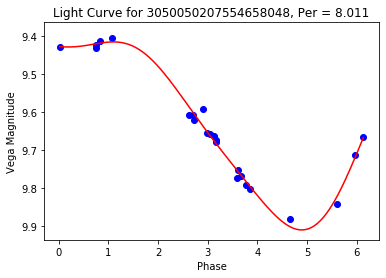

C_calc = -6.829334143017711
Index = 589
Source = 3051144427784813824
Period = 3.4540339073973794
C_flux = 91533.07768222233
C_mag = 13.317787311505143
C_calc = 13.284420562114654


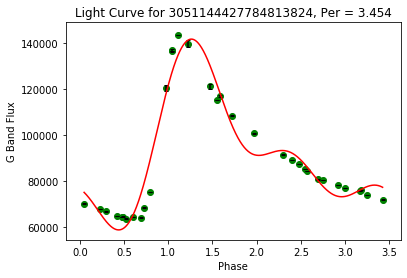

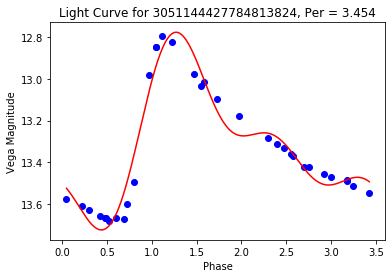

C_calc = 1.3337691636886984
Index = 590
Source = 3051692843568009600
Period = 4.7880073718758
C_flux = 182185.5314046331
C_mag = 12.553675002498808
C_calc = 12.537081015819018


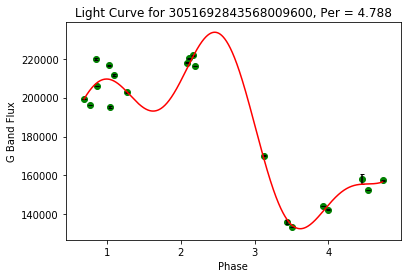

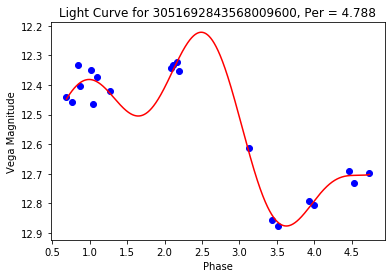

C_calc = -0.801911519394606
Index = 591
Source = 3052092481686246016
Period = 3.9471518826425602
C_flux = 187723.71074834594
C_mag = 12.528947207917195
C_calc = 12.504567899229164


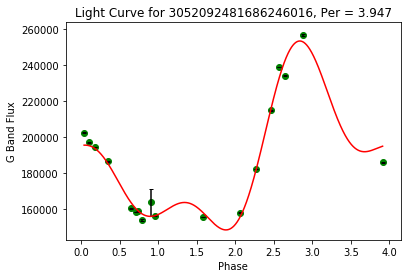

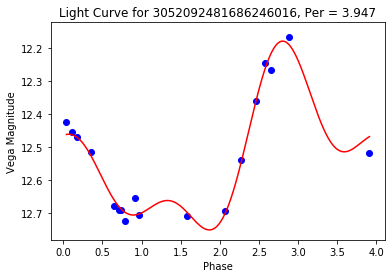

C_calc = -0.7665416576135229


In [66]:
#ThreeDegFit('light_curves_first.txt')
ThreeDegFit('lcs_3044.txt')

## Comparing my Calculated Average Magnitude with the Published Magnitude

In [68]:
r['int_average_g'][np.argwhere(r['source_id']==3046774762417915136)]

7.830550402788656


## Six Degree Fourier Fit

In [25]:
p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_offset]

def my_sin(x,freq,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,offset):
    deg1 = (np.sin(2*np.pi*x*freq)*amp1) + (np.cos(2*np.pi*x*freq)*amp2)
    deg2 = (np.sin(2*np.pi*2*x*freq)*amp3) + (np.cos(2*np.pi*2*x*freq)* amp4)
    deg3 = (np.sin(2*np.pi*3*x*freq)*amp5) + (np.cos(2*np.pi*3*x*freq)* amp6)
    deg4 = (np.sin(2*np.pi*4*x*freq)*amp7) + (np.cos(2*np.pi*4*x*freq)* amp8)
    deg5 = (np.sin(2*np.pi*5*x*freq)*amp9) + (np.cos(2*np.pi*5*x*freq)* amp10)
    deg6 = (np.sin(2*np.pi*6*x*freq)*amp11) + (np.cos(2*np.pi*6*x*freq)* amp12)
    return offset + deg1 + deg2 + deg3 + deg4 + deg5 + deg6

fit = curve_fit(my_sin, myt, data, p0=p0)

## Conversion Factor Example

In [60]:
fluxy = 1.3344499230519688E7
fluxylog = -2.5*np.log10(fluxy)
magy = 7.875110022692443
fluxylog - magy

-25.688365725119546